In [0]:
import sys
import core
from core import *
sys.path.append("..")
import torch
from torchvision import transforms
import torchvision
import torch.utils.data as Data
import numpy as np
from torch.autograd import Variable
import random
import math
import itertools
import argparse
import pickle
import torch.nn.functional as f

# check whether we are using GPU or not
use_cuda = torch.cuda.is_available()

N_Epochs =  600
N_units = 1200
LearningRate = 0.001
BatchSize = 128
optimizer_type = "SGD"
preprocess = True
N_Samples_Training = 2
N_Samples_Testing = 100
prior_type = "scale_mixture"
mixture_sigma1 = torch.tensor([math.exp(-2)])
mixture_sigma2 = torch.tensor([math.exp(-8)])
if use_cuda:
    mixture_sigma1 = mixture_sigma1.cuda()
    mixture_sigma2 = mixture_sigma2.cuda()
mixture_pi = 0.75
network_type = "bayesian"
initial_mu_weights = [-0.08, 0.08]
initial_rho_weights = [-2.5,-2.1]
initial_mu_bias = [-0.08, 0.08]
initial_rho_bias = [-2.5,-2.1]
use_normalized = False


import os.path
dataset_path = os.path.join(os.path.dirname(""), 'mnist_dataset')
if not os.path.exists(dataset_path):
    Download_MNIST = True
else:
    Download_MNIST = False

if preprocess is True:
    # transform = transforms.Compose([np.array, torch.FloatTensor, lambda x: torch.div(x,126.0)])
    transform = transforms.Compose([torchvision.transforms.ToTensor(), lambda x: x*255/126])
else:
    transform = transforms.Compose([np.array, torch.FloatTensor])

train_set = torchvision.datasets.MNIST(
    root=dataset_path,
    train=True,
    transform=transform,
    download=Download_MNIST
)

train_loader = Data.DataLoader(dataset=train_set, batch_size=BatchSize, shuffle=True)

test_set = torchvision.datasets.MNIST(
    root=dataset_path,
    train=False,
    transform=transform,
    download=Download_MNIST
)

train_size = train_set.train_data.size()[0]
N_Train_Batch = train_size / BatchSize
test_size = test_set.test_data.size()[0]

compute_accu = lambda pred, true, digits: round((pred == true).mean() * 100, digits)

# build the network
if network_type == "standard":
    loss_fn = torch.nn.NLLLoss(reduction='sum')
    if use_dropout:
        dropout_rate = args.dropout_rate
        net =  torch.nn.Sequential(
            torch.nn.Linear(784, N_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(N_units, N_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(N_units, 10),
            torch.nn.LogSoftmax(dim=1)
        )
    else:
        net = torch.nn.Sequential(
            torch.nn.Linear(784, N_units),
            torch.nn.ReLU(),
            torch.nn.Linear(N_units, N_units),
            torch.nn.ReLU(),
            torch.nn.Linear(N_units, 10),
            torch.nn.LogSoftmax(dim=1)
        )

elif network_type == "bayesian":
    if prior_type == 'scale_mixture':
        prior_type = PriorType.MIXTURE
        prior_params={'pi' : mixture_pi, 'sigma1' : mixture_sigma1, 'sigma2' : mixture_sigma2}
    else:
        prior_type = PriorType.GAUSSIAN
        prior_params={'mean': gaussian_mean, 'sigma': gaussian_sigma}
    net = BayesianNN(
        nn_input_size=784,
        layer_config=[N_units, N_units, 10],
        activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.SOFTMAX],
        prior_type=prior_type,
        prior_params=prior_params,
        task_type=TaskType.CLASSIFICATION,
        initial_mu_weights=initial_mu_weights,
        initial_rho_weights=initial_rho_weights,
        initial_mu_bias=initial_mu_bias,
        initial_rho_bias=initial_rho_bias
    )
    print("initial mu weights:", initial_mu_weights)
    print("initial rho weights:", initial_rho_weights)
    print("initial mu bias:", initial_mu_bias)
    print("initial rho bias", initial_rho_bias)
else:
    raise ValueError

if use_cuda:
    net = net.cuda()

print(net)

# build the optimizer
if optimizer_type == "SGD":
    optim = torch.optim.SGD(net.parameters(), lr=LearningRate)
elif optimizer_type == "Adam":
    optim = torch.optim.Adam(net.parameters(), lr=LearningRate)
else:
    raise ValueError

#scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
# the main training loop
train_accu_lst = []
test_accu_lst = []

test_X = Variable(test_set.test_data.view(test_size, -1).type(torch.FloatTensor))
test_Y = Variable(test_set.test_labels.view(test_size, -1))

if use_cuda:
    test_X, test_Y = test_X.cuda(), test_Y.cuda()

train_X = Variable(train_set.train_data.view(train_size, -1).type(torch.FloatTensor))
train_Y = Variable(train_set.train_labels.view(train_size, -1))

if use_cuda:
    train_X, train_Y = train_X.cuda(), train_Y.cuda()
import time
normalized_factor = 1/N_Train_Batch
# for i_ep in range(N_Epochs):
#     #scheduler.step()
#     # Training
#     net.train()
#     if use_normalized:
#         normalized_factor = 1
#     total_loss = 0
#     total_kl = 0
#     start = time.time()
#     for X, Y in train_loader:
#         batch_X = Variable(X.view(X.size()[0], -1))
#         batch_Y = Variable(Y.view(X.size()[0]))

#         if use_normalized:
#             normalized_factor /= 2
#         if use_cuda:
#             batch_X, batch_Y = batch_X.cuda(), batch_Y.cuda()

#         # compute loss
#         if network_type == 'standard':
#             y_pred = net(batch_X)
#             loss = loss_fn(y_pred, batch_Y)
#         elif network_type == 'bayesian':
#             loss, kl , _ = net.cost_function(batch_X, batch_Y, num_samples=N_Samples_Training, ratio = normalized_factor)
#             total_loss += loss.item()
#             total_kl += kl.item()
#             # detect nan
#             if torch.isnan(loss):
#                 print("Loss NAN.")
#                 for p in net.parameters():
#                     print(p)
#                 raise ValueError
#         else:
#             raise ValueError

#         # do backpropagation
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#     end = time.time()
#     print(end-start)
#     # Evaluate on training set
#     if network_type == 'standard':
#         net.eval()
#     # do not use evaluation mode for bayesian networks because we do sampling during testing
#     if network_type == 'bayesian':
#         print(total_loss, total_kl)

#     # test on training set

#     if network_type == 'standard':
#         pred_class = net(train_X).cpu().data.numpy().argmax(axis=1)
#     elif network_type == 'bayesian':
#         pred_class = net.predict_by_sampling(train_X, num_samples=N_Samples_Testing).data.cpu().numpy().argmax(axis=1)
#     else:
#         raise ValueError

#     true_class = train_Y.data.cpu().numpy().ravel()

#     train_accu = compute_accu(pred_class, true_class, 2)
#     print('Epoch', i_ep, '|  Training Accuracy:', train_accu, '%', '| Training Error: ', round(100-train_accu, 2), '%')

#     train_accu_lst.append(train_accu)

#     # test on testing set

#     true_class = test_Y.data.cpu().numpy().ravel()

#     if network_type == 'standard':
#         pred_class = net(test_X).cpu().data.numpy().argmax(axis=1)
#     elif network_type == 'bayesian':
#         pred_class = net.predict_by_sampling(test_X, num_samples=N_Samples_Testing).data.cpu().numpy().argmax(axis=1)
#         pred_class_without_sampling = net(test_X, sample=False).cpu().detach().numpy().argmax(axis=1)
#         test_accu_without_sampling = compute_accu(pred_class_without_sampling, true_class, 2)
#         print('Epoch', i_ep, '|  Test Accuracy without sampling:', test_accu_without_sampling, '%', '| Test Error: ', round(100-test_accu_without_sampling, 2), '%')
#         pred_class_2 = net.predict_by_sampling(test_X, num_samples=2).data.cpu().numpy().argmax(axis=1)
#         #pred_class_4 = net.predict_by_sampling(test_X, num_samples=4).data.cpu().numpy().argmax(axis=1)
#         #pred_class_6 = net.predict_by_sampling(test_X, num_samples=6).data.cpu().numpy().argmax(axis=1)
#         pred_class_20 = net.predict_by_sampling(test_X, num_samples=20).data.cpu().numpy().argmax(axis=1)
#         #pred_class_100 = net.predict_by_sampling(test_X, num_samples=100).data.cpu().numpy().argmax(axis=1)
#         #pred_class_300 = net.predict_by_sampling(test_X, num_samples=300).data.cpu().numpy().argmax(axis=1)
#         print("sample 2 test error: {}".format(100-compute_accu(pred_class_2, true_class, 2)))
#         #print("sample 4 test error: {}".format(100-compute_accu(pred_class_4, true_class, 2)))
#         #print("sample 6 test error: {}".format(100-compute_accu(pred_class_6, true_class, 2)))
#         print("sample 20 test error: {}".format(100-compute_accu(pred_class_20, true_class, 2)))
#         #print("sample 100 test error: {}".format(100-compute_accu(pred_class_100, true_class, 2)))
#         #print("sample 300 test error: {}".format(100-compute_accu(pred_class_300, true_class, 2)))
#     else:
#         raise ValueError

#     test_accu = compute_accu(pred_class, true_class, 2)
#     print('Epoch', i_ep, '|  Test Accuracy:', test_accu, '%', '| Test Error: ', round(100-test_accu, 2), '%')

#     test_accu_lst.append(test_accu)

# for p in net.parameters():
#     print(p)

# # to report the final test error, I will use the average of test errors of the last 10 epochs

# report_test_accu_mean = np.average(test_accu_lst[-10:])
# report_test_accu_std = np.std(test_accu_lst[-10:])
# report_test_error_mean = round(100-report_test_accu_mean, 2)
# print("Test Accuracy: {}".format(report_test_accu_mean))
# print("Test Error: {}".format(report_test_error_mean))
# print("Test Accuracy/Error Std: {}".format(report_test_accu_std))

# # save result to results folder: using pickle
# result_folder_path = "../../results/{}/".format(experiment_name)
# if not os.path.exists(result_folder_path):
#     os.mkdir(result_folder_path)
# with open(result_folder_path+"train_accu_lst.pkl", 'wb') as f:
#     pickle.dump(train_accu_lst, f)
# with open(result_folder_path+"test_accu_lst.pkl", 'wb') as f:
#     pickle.dump(test_accu_lst, f)

Use GPU: True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


initial mu weights: [-0.08, 0.08]
initial rho weights: [-2.5, -2.1]
initial mu bias: [-0.08, 0.08]
initial rho bias [-2.5, -2.1]
BayesianNN(
  Bayesian Layer, in_size:784, out_size:1200, activation_type:RELU
  Bayesian Layer, in_size:1200, out_size:1200, activation_type:RELU
  Bayesian Layer, in_size:1200, out_size:10, activation_type:SOFTMAX
  
  (layers): ModuleList(
    (0): BayesianLayer(Bayesian Layer, in_size:784, out_size:1200, activation_type:RELU)
    (1): BayesianLayer(Bayesian Layer, in_size:1200, out_size:1200, activation_type:RELU)
    (2): BayesianLayer(Bayesian Layer, in_size:1200, out_size:10, activation_type:SOFTMAX)
  )
)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [0]:
bayesian3_net = torch.load("bayes3_weights.pt").cuda()
bayesian1_net = torch.load("bayes1_weights.pt")
net = bayesian1_net
arr = []
for i in range (len(net.layers)):
  weightdb = torch.log(torch.abs(net.layers[i].mu_weights)/torch.log(1 + torch.exp(net.layers[i].rho_weights))).view(-1).data.cpu().numpy()
  arr.extend(weightdb)
  biasdb = torch.log(torch.abs(net.layers[i].mu_bias)/torch.log(1 + torch.exp(net.layers[i].rho_bias))).view(-1).data.cpu().numpy()
  arr.extend(biasdb)
plt.hist(arr, bins = 10000, label="-0.0")
net = bayesian3_net
arr = []
for i in range (len(net.layers)):
  weightdb = torch.log(torch.abs(net.layers[i].mu_weights)/torch.log(1 + torch.exp(net.layers[i].rho_weights))).view(-1).data.cpu().numpy()
  arr.extend(weightdb)
  biasdb = torch.log(torch.abs(net.layers[i].mu_bias)/torch.log(1 + torch.exp(net.layers[i].rho_bias))).view(-1).data.cpu().numpy()
  arr.extend(biasdb)
plt.hist(arr, bins = 10000, label="-2.0")
plt.legend()

'plt.hist(arr, bins = 10000, label="-0.0")\nnet = bayesian3_net\narr = []\nfor i in range (len(net.layers)):\n  weightdb = torch.log(torch.abs(net.layers[i].mu_weights)/torch.log(1 + torch.exp(net.layers[i].rho_weights))).view(-1).data.cpu().numpy()\n  arr.extend(weightdb)\n  biasdb = torch.log(torch.abs(net.layers[i].mu_bias)/torch.log(1 + torch.exp(net.layers[i].rho_bias))).view(-1).data.cpu().numpy()\n  arr.extend(biasdb)\n    #net.layers[i].mu_weights\nplt.hist(arr, bins = 10000, label="-2.0")\nplt.legend()'

In [0]:
net = torch.load("bayes1_weights.pt").cuda()
def get_error(net, percentile, arr):
  arr = np.sort(arr)
  threshold = arr[int(len(arr)*percentile)]
  for i in range (len(net.layers)):
    for j in range (len(net.layers[i].mu_weights)):
      t = (torch.log(torch.abs(net.layers[i].mu_weights[j])/torch.log(1 + torch.exp(net.layers[i].rho_weights[j]))) < threshold)
      t = t.nonzero()
      net.layers[i].mu_weights[j][t] = 0
      net.layers[i].rho_weights[j][t] = -15
  pred_class = net.predict_by_sampling(test_X, 100).data.cpu().numpy().argmax(axis=1)
  true_class = test_Y.data.cpu().numpy().ravel()
  test_accu = (pred_class == true_class).sum()
  return round((1-test_accu/len(test_X))*100,2)
print("0% of weights removed:", get_error(net, 0, arr))
print("50% of weights removed:", get_error(net, 0.5, arr))
print("75% of weights removed:", get_error(net, 0.75, arr))
print("95% of weights removed:", get_error(net, 0.95, arr))
print("98% of weights removed:", get_error(net, 0.98, arr))

0% of weights removed: 1.32
50% of weights removed: 2.19
75% of weights removed: 5.45
95% of weights removed: 13.03
98% of weights removed: 18.93


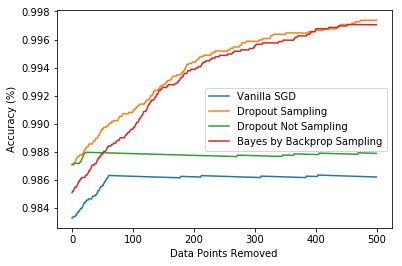

In [0]:
import core
sgd_net = torch.load("SGD_weights.pt")
dropout_net = torch.load("dropout_weights.pt")
dropout_net.train()
bayesian_net = torch.load("bayes_weights.pt")

def expected_entropy(net, input_data, num_samples=100):
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], 10)
        for i in range(num_samples):
            outputs[i] = net.forward(input_data)
            outputs[i] = torch.exp(outputs[i])+1e-45
        outputs = outputs.mean(0)
        MC = torch.sum(outputs*torch.log(outputs), dim = 1)
    #MC = MC.mean(0)
    return MC

def test(net, label, bayesian=False, dropout=False):
    if dropout is True:
        net.eval()
    test_accu_lst = []
    if bayesian is True:
       pred_class = net.predict_by_sampling(test_X, 100).data.cpu().numpy().argmax(axis=1)
    else:
        pred_class = net(test_X).data.cpu().numpy().argmax(axis=1)
    true_class = test_Y.data.cpu().numpy().ravel()
    test_accu = (pred_class == true_class).sum()
    if dropout is True:
        net.train()
    entropy = expected_entropy(net, test_X, 100)
    entropy = entropy.data.cpu().numpy().ravel()
    equ = pred_class == true_class
    entropy_pair = sorted(list(zip(entropy, equ)), key=lambda tup: tup[0])
    cur_test_size = test_size
    for i in range(500):
      cur_test_size-=1
      if(entropy_pair[i][1]):
        test_accu -= 1
      test_accu_lst.append(test_accu/cur_test_size)
    plt.plot(test_accu_lst, label=label)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Data Points Removed')
    # plt.show()

test(sgd_net, "Vanilla SGD")
dropout_net.train()
test(dropout_net, "Dropout Sampling", dropout=True)
dropout_net.eval()
test(dropout_net, "Dropout Not Sampling")
test(bayesian_net, "Bayes by Backprop Sampling", bayesian=True)
plt.legend()
plt.show()


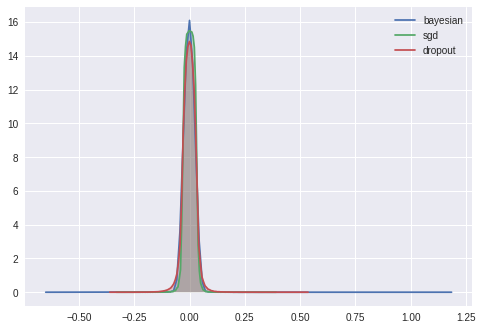

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import core

sgd_net = torch.load("SGD_weights.pt")
dropout_net = torch.load("dropout_weights.pt")
dropout_net.eval()
bayesian_net = torch.load("bayes3_weights.pt")


bayesian_parameters = list(bayesian_net.parameters())
bayesian_parameters = np.concatenate([bayesian_parameters[i].data.cpu().numpy().reshape(-1,) for i in range(len(bayesian_parameters)) if i % 2 == 0])

dropout_parameters = list(dropout_net.parameters())
dropout_parameters = np.concatenate([dropout_parameters[i].data.cpu().numpy().reshape(-1,) for i in range(len(dropout_parameters))])

sgd_parameters = list(sgd_net.parameters())
sgd_parameters = np.concatenate([sgd_parameters[i].data.cpu().numpy().reshape(-1, ) for i in range(len(sgd_parameters))])

sns.kdeplot(bayesian_parameters, shade=True, label="bayesian")
sns.kdeplot(sgd_parameters, shade=True, label="sgd")
sns.kdeplot(dropout_parameters, shade=True, label="dropout")

plt.legend()